# Actividad PBL 2

Alejandro Hermosillo García - A01634552
<br>
Ana Paula Ponce Dávila - A01620477
<br>
Andrés Olvera Varela - A01639918
<br>
Ernesto Godínez Medina - A01633812
<br>
Mauricio Flores Pérez - A01639917


## Instalación de paquetes

In [2]:
!pip install pyagrum pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 3.7 MB/s 


## Importación de librerías 

In [3]:
import numpy as np
import pandas as pd 

from pylab import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

import pyAgrum as gum 
import pyAgrum.lib.notebook as gnb
#import pyAgrum.lib.bn2roc import showROC

from collections import Counter
from IPython.core.display import display, HTML
import time 
import logging 

from google.colab import drive 
drive.mount('/content/drive')

** pyAgrum** For better visualizations, please install matplotlib-inline.
Mounted at /content/drive


## Funciones y formateo

In [4]:
# Formateo 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width_100% !important; }</style>"))
%matplotlib inline

path = '/content/drive/Shareddrives/Analisis Incertidumbre (PEDRO)/'

# Funciones
def missing(df, perc=0):
  missing_df = df.isnull().sum().reset_index()
  missing_df.columns = ['column', 'missing count']
  missing_df['percentage'] = (missing_df['missing count'])/df.shape[0]*100
  missing_df = missing_df[missing_df.percentage>perc]
  print('#columns containg missing values', len(missing_df))
  print('missing_columns=', list(missing_df.column))
  return missing_df.sort_values(by='percentage', ascending=False)

def show_unique(df):
  counts = pd.DataFrame()
  counts['nunique'] = df.nunique()
  counts = counts[counts['nunique'] == 1]
  print('These columns only have one value:', list(counts.index))
  return counts 

def fill_null(df, attribute_list, stat = 'intger', integer = -999):
  for i in attribute_list:
    if stat == 'median':
      df[i].fillna(df[i].median(), inplace =True)
    elif stat == 'mean':
      df[i].fillna(df[i].mean(), inplace =True)
    elif stat == 'mode':
      df[i].fillna(df[i].mode()[0], inplace =True)
    elif stat == 'integer':
      df[i].fillna(integer, inplace =True)
  return df

def get_jpd_size(bn):
  return np.prod([bn.variable(node).domainSize() for node in bn.nodes()])

def get_cpts_size(bn):
  return sum([np.prod(bn.cpt(node).var_dims) for node in bn.nodes()])

def compression_ratio(bn):
  return 100*(1-get_cpts_size(bn)/ get_jpd_size(bn))

def post(row, bn, target):
  ie = gum.LazyPropagation(bn)
  evs = row.astype(str).to_dict()
  del evs[target]
  ie.setEvidence(evs)
  ie.addTarget(target)
  return ie.posterior(target).toarray()[1]

In [5]:
class BNEstimator(BaseEstimator, ClassifierMixin):
  def __init__(self,
               csv_template=None,
               bn=None,
               mandatory_arcs=[],
               tabu_arcs=[],
               class_name=None,
               learning_method='greedy',
               prior='likelihood',
               prior_weight=.5,
               positif_label=None,
               threshold=.5,
               nb_classes=2,
               cut_points_percentiles=list(100*np.linspace(0,1,5)),
               bins=5):
    
    self.csv_template = csv_template
    self.mandatory_arcs = mandatory_arcs
    self.tabu_arcs = tabu_arcs
    self.class_name = class_name
    self.learning_method = learning_method
    self.prior = prior
    self.prior_weight = prior_weight
    self.positif_label = positif_label
    self.threshold = threshold
    self.nb_classes = nb_classes
    self.cut_points_percentiles = cut_points_percentiles
    self.bins = bins
    self.bn = bn


  def set_params(self, **parameters):
    for parameter, value in parameters.items():
      setattr(self, parameter, value)
    return self

  
  def transform(self, d):
    template = gum.BayesNet()
    numeric_cols = list(d.select_dtypes(include=[np.number]).columns)
    categorical_cols = list(d.select_dtypes(include=[object]).columns)
    
    for col in numeric_cols:
      if d[col].value_counts().shape[0]>self.bins:
        x = d[col].values.flatten()
        x.sort()
        cut_points = np.percentile(x, self.cut_points_percentiles)
        d.loc[:, col] = np.digitize(x, cut_points, right=False)
        del x 
      template.add(gum.LabelizedVariable(col, col, list(map(str, d[col].value_counts().index))))
    for col in categorical_cols:
      if d[col].value_counts().shape[0]>self.bins:
        top = d[col].isin(d[col].value_counts().index[:self.bins])
        d.loc[~top, col] = "else_top_"+str(self.bins)
        del top 
      template.add(gum.LabelizedVariable(col, col, list(map(str, d[col].value_counts().index))))
    return template, d


  def fit(self, data, y=None):
    template,_ = self.transform(pd.read_csv(self.csv_template))
    _,train = self.transform(data)

    train.to_csv('train_bn.csv', index = False)
    learner = gum.BNLearner('train_bn.csv', template)

    for i in self.tabu_arcs : learner.addForbiddenArc(i[0], i[1])
    for i in self.mandatory_arcs : learner.addMandatoryArc(i[0], i[1])

    if self.learning_method == 'greedy':learner.useGreedyHillClimbing()
    else: learner.useMIIC()

    if self.prior == 'laplace':learner.useAprioriSmoothing(self.prior_weight)
    else:learner.useNoApriori()

    self.bn = learner.learnBN()
    self.bn = learner.learnParameters(self.bn.dag())
    del template, train

    return self 


  def predict_one_row(self, row):
    ie = gum.LazyPropagation(self.bn)
    ie.addTarget(self.class_name)

    evs = row.astype(str).todict()
    del evs[self.class_name]
    ie.setEvidence(evs)
    ie.makeInference
    return ie.posterior(self.class_name).toarray()

  
  def predict_proba(self, Xtest):
    if type(Xtest) is np.ndarray:
      Xtest = pd.DataFrame(Xtest, columns=["X{}".format(i) for i in range(Xtest.shape[1])])

    Yscores = np.empty([Xtest.shape[0], self.nb_classes])
    Yscores[:] = np.nan

    mbnames = [self.bn.variable(i).name()
               for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()
               if self.bn.variable(i).name() != self.class_name]
    ie = gum.LazyPropagation(self.bn)
    for var in ie.BN().names():
      if var != self.class_name:
        ie.addEvidence(var, 0)
    ie.addTarget(self.class_name)

    Xtest = Xtest.reset_index(drop=True)

    for line in Xtest.itertuples():
      for var in mbnames:
        try:
          idx = self.bn.variable(var).index(str(getattr(line, var)))
          ie.chgEvidence(var, idx)
        except gum.GumException:
          print("[pyAgrum] ** pyAgrum.lib.classifier : The value {getattr(line, var)} for the variable {var} is missing in the training set.")
          pass

      ie.makeInference()

      marginal = ie.posterior(self.class_name)
      Yscores[line[0]] = marginal.toarray()

    return Yscores


  def predict(self, test):
    y_scores = self.predict_proba(test)[:, 1]
    y_true = test[self.class_name]

    return y_true, np.where(y_Scores >= self.threshold, 1, 0)

  
  def score(self, test):
    y_true, y_pred = self.predict(test)
    print(classification_report(y_true, y_pred))
    print(5*'--')
    print('Recall score')
    return recall_score(y_true, y_pred)

## Programa Principal

In [6]:
df_o = pd.read_excel(path + 'dataset.xlsx')
df = df_o.copy()
print('Dimensiones de los datos: ', df.shape)
df.head()

Dimensiones de los datos:  (5644, 111)


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.237,-0.022,-0.517,0.011,0.102,0.318,-0.951,-0.095,-0.224,-0.292,1.482,0.166,0.358,-0.625,-0.141,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619,1.198,-0.148,2.090,-0.306,0.863,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,N

In [7]:
# Rename some columns to make our lives easier
df.rename(columns= {'SARS-Cov-2 exam result': 'covid_19',
                   'Patient addmited to regular ward (1=yes, 0=no)': 'regular_ward', 
                   'Patient addmited to semi-intensive unit (1=yes, 0=no)': 'semi_intensive_care',
                   'Patient addmited to intensive care unit (1=yes, 0=no)': 'intensive_care',
                   'Influenza B, rapid test': 'Influenza B rapid test',
                   'Influenza A, rapid test': 'Influenza A rapid test'}, inplace = True)

# Dummify covid_19 var for consistency
df['covid_19'] = df['covid_19'].apply(lambda x :1 if x=='positive' else 0)

# We don't really need patient IDs, so we drop them
df.drop(columns = 'Patient ID', inplace = True)

In [8]:
df.drop(columns = list(missing(df, perc = 95).column.values), inplace = True)
df.drop(columns = list(show_unique(df).index), inplace = True )
df.shape

#columns containg missing values 65
missing_columns= ['Serum Glucose', 'Mycoplasma pneumoniae', 'Alanine transaminase', 'Aspartate transaminase', 'Gamma-glutamyltransferase\xa0', 'Total Bilirubin', 'Direct Bilirubin', 'Indirect Bilirubin', 'Alkaline phosphatase', 'Ionized calcium\xa0', 'Magnesium', 'pCO2 (venous blood gas analysis)', 'Hb saturation (venous blood gas analysis)', 'Base excess (venous blood gas analysis)', 'pO2 (venous blood gas analysis)', 'Fio2 (venous blood gas analysis)', 'Total CO2 (venous blood gas analysis)', 'pH (venous blood gas analysis)', 'HCO3 (venous blood gas analysis)', 'Rods #', 'Segmented', 'Promyelocytes', 'Metamyelocytes', 'Myelocytes', 'Myeloblasts', 'Urine - Esterase', 'Urine - Aspect', 'Urine - pH', 'Urine - Hemoglobin', 'Urine - Bile pigments', 'Urine - Ketone Bodies', 'Urine - Nitrite', 'Urine - Density', 'Urine - Urobilinogen', 'Urine - Protein', 'Urine - Sugar', 'Urine - Leukocytes', 'Urine - Crystals', 'Urine - Red blood cells', 'Urine - Hyaline

(5644, 44)

In [9]:
kept_cols = [i for i in df if df[i].nunique()<=4]
kept_cols.extend(['Platelets', 'Red blood Cells', 'Lymphocytes', 'Leukocytes'])
kept_cols, len(kept_cols)

(['covid_19',
  'regular_ward',
  'semi_intensive_care',
  'intensive_care',
  'Respiratory Syncytial Virus',
  'Influenza A',
  'Influenza B',
  'Parainfluenza 1',
  'CoronavirusNL63',
  'Rhinovirus/Enterovirus',
  'Coronavirus HKU1',
  'Parainfluenza 3',
  'Chlamydophila pneumoniae',
  'Adenovirus',
  'Parainfluenza 4',
  'Coronavirus229E',
  'CoronavirusOC43',
  'Inf A H1N1 2009',
  'Bordetella pertussis',
  'Metapneumovirus',
  'Influenza B rapid test',
  'Influenza A rapid test',
  'Strepto A',
  'Platelets',
  'Red blood Cells',
  'Lymphocytes',
  'Leukocytes'],
 27)

In [10]:
missing(df_o)

#columns containg missing values 105
missing_columns= ['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes', 'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes', 'Red blood cell distribution width (RDW)', 'Serum Glucose', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Mycoplasma pneumoniae', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2', 'Neutrophils', 'Urea', 'Proteina C reativa mg/dL', 'Creatinine', 'Potassium', 'Sodium', 'Influenza B, rapid test', 'Influenza A, rapid test', 'Alanine transaminase', 'Aspartate transaminase', 'Gamma-glutamyltransferase\xa0', 'Total Bili

,column,missing count,percentage
81,Urine - Sugar,5644,100.000
89,Partial thromboplastin time (PTT),5644,100.000
27,Mycoplasma pneumoniae,5644,100.000
93,"Prothrombin time (PT), Activity",5644,100.000
99,D-Dimer,5644,100.000
...,...,...,...
24,Parainfluenza 1,4292,76.045
32,Parainfluenza 4,4292,76.045
21,Respiratory Syncytial Virus,4290,76.010
22,Influenza A,4290,76.010


In [11]:
df = df[kept_cols]
missing(df)

#columns containg missing values 23
missing_columns= ['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Influenza B rapid test', 'Influenza A rapid test', 'Strepto A', 'Platelets', 'Red blood Cells', 'Lymphocytes', 'Leukocytes']


,column,missing count,percentage
22,Strepto A,5312,94.118
26,Leukocytes,5042,89.334
25,Lymphocytes,5042,89.334
24,Red blood Cells,5042,89.334
23,Platelets,5042,89.334
21,Influenza A rapid test,4824,85.471
20,Influenza B rapid test,4824,85.471
16,CoronavirusOC43,4292,76.045
19,Metapneumovirus,4292,76.045
18,Bordetella pertussis,4292,76.045


In [12]:
continuous_cols = [x for x in df.columns if df[x].dtypes == 'float64']
discrete_cols = [x for x in df.columns if (df[x].dtypes == 'O') | (df[x].dtypes == 'int64')]
for i in ['covid_19', 'regular_ward', 'semi_intensive_care', 'intensive_care']:
  discrete_cols.remove(i)

df = fill_null(df, continuous_cols, stat = 'median')
df = fill_null(df, discrete_cols, stat = 'integer', integer = '-999')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inpla

In [23]:
df.to_csv(path + 'template.csv', index = False)

clf = BNEstimator(csv_template = path + 'template.csv', class_name = 'covid_19', cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df)

train,test = train_test_split(data, test_size = .25, random_state = 42)
train.to_csv(path + 'train.csv', index = False)

clf.fit(train)

BNEstimator(bn=(pyAgrum.BayesNet<double>@0x6524000) BN{nodes: 27, arcs: 45, domainSize: 10^12.8026, dim: 645},
            class_name='covid_19',
            csv_template='/content/drive/Shareddrives/Analisis Incertidumbre '
                         '(PEDRO)/template.csv',
            cut_points_percentiles=[5, 50, 95])

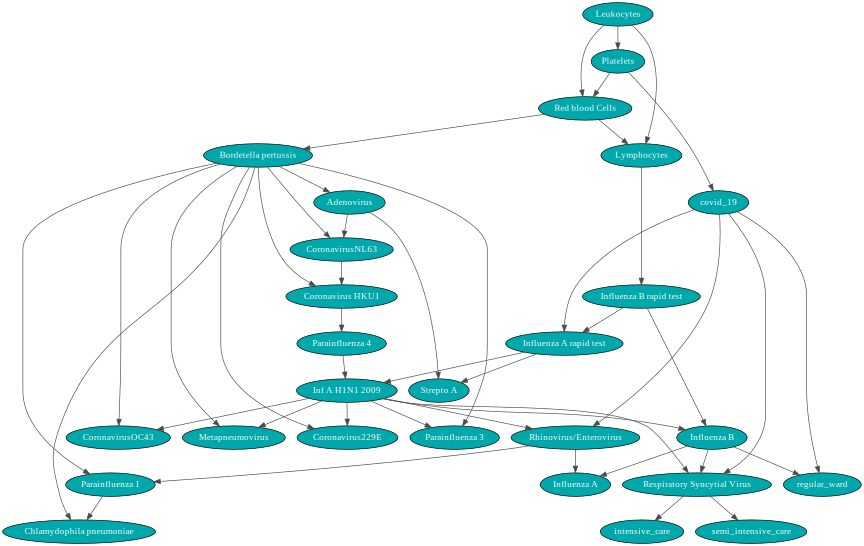

In [27]:
gnb.showBN(clf.bn, size=12, nodeColor={n:0.66 for n in clf.bn.names()}, cmap=plt.cm.get_cmap('winter'))

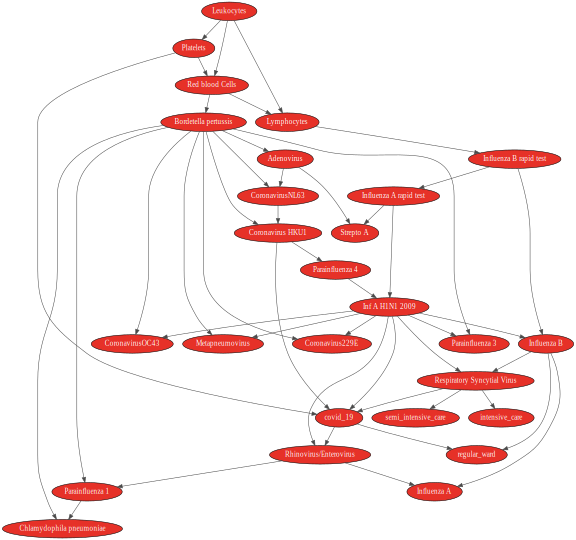

In [86]:
df.to_csv(path + 'template.csv', index = False)

clf = BNEstimator(csv_template = path + 'template.csv', class_name = 'covid_19', 
                  tabu_arcs = [('Influenza B rapid test', 'covid_19')],
                  mandatory_arcs = [('Coronavirus HKU1', 'covid_19'), ('Respiratory Syncytial Virus', 'covid_19')],
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df)

train,test = train_test_split(data, test_size = .25, random_state = 42)
train.to_csv(path + 'train.csv', index = False)
test.to_csv(path + 'test.csv', index = False)


clf.fit(train)

gnb.showBN(clf.bn, size = 8, nodeColor={n:0.66 for n in clf.bn.names()}, cmap=plt.cm.get_cmap('Reds'))

In [87]:
gum.MarkovBlanket(clf.bn, 'covid_19')

<pyAgrum.pyAgrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x7fd4692e4510> >

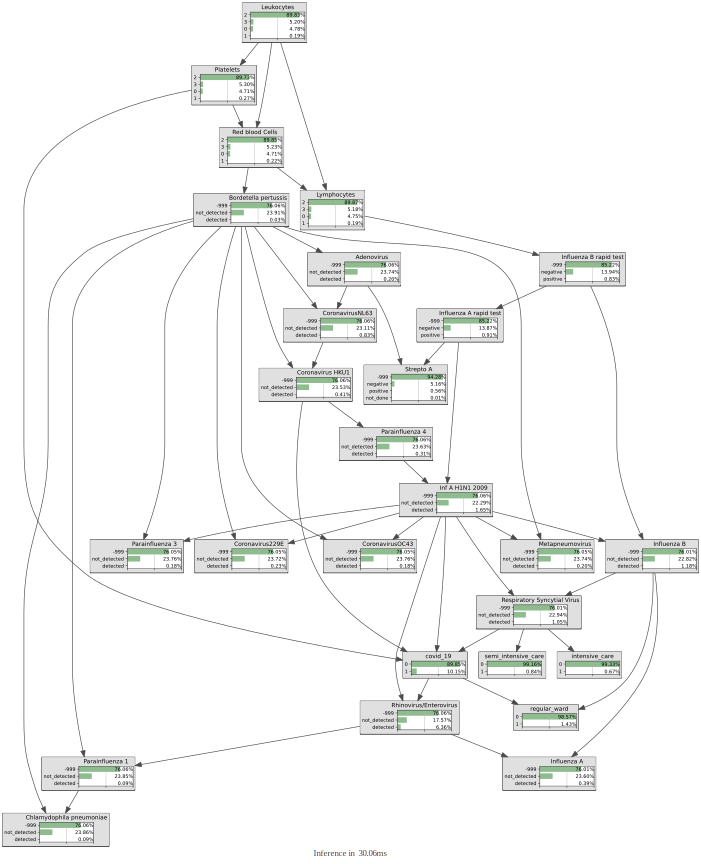

In [88]:
gnb.showInference(clf.bn, size=12)

** pyAgrum** For better visualizations, please install matplotlib-inline.


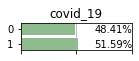

In [89]:
d_test = pd.read_csv(path + 'test.csv')
row = d_test.loc[1, :]
evs = row.astype(str).to_dict()

evidence = {'Platelets': '3',
            'Inf A H1N1 2009': 'not_detected',
            'Influenza B': 'not_detected',
            'Respiratory Syncytial Virus': 'detected',
            'Coronavirus HKU1': 'detected',
            'Rhinovirus/Enterovirus': 'not_detected',
            'Influenza A': 'detected',
            'regular_ward': 0}

gnb.showPosterior(clf.bn,
                  target='covid_19',
                  evs=evidence)

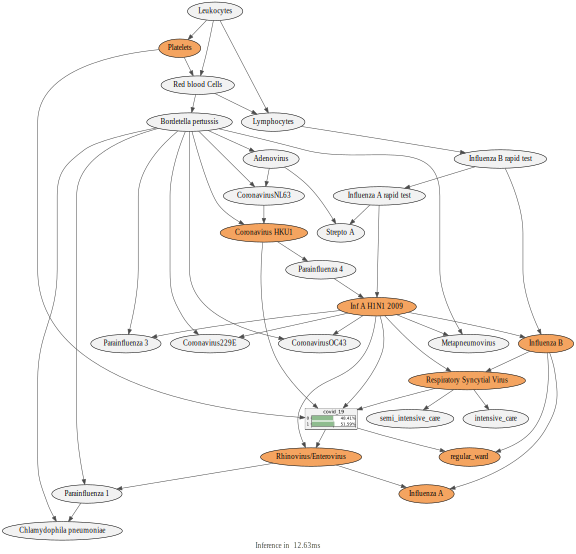

In [90]:
MB = gum.MarkovBlanket(clf.bn, 'covid_19')

gnb.showInference(clf.bn,
                  nodeColor={n:0.9 for n in clf.bn.names()},
                  evs=evidence,
                  targets={'covid_19'},
                  size=8)

In [91]:
clf.bn.cpt(clf.bn.idFromName('regular_ward'))

(pyAgrum.Potential<double>@0x64678a0) 
             ||  regular_ward     |
Influe|covid_||0        |1        |
------|------||---------|---------|
-999  |0     || 0.9975  | 0.0025  |
not_de|0     || 0.9705  | 0.0295  |
detect|0     || 0.9983  | 0.0017  |
-999  |1     || 0.9795  | 0.0205  |
not_de|1     || 0.7495  | 0.2505  |
detect|1     || 0.9286  | 0.0714  |